In [1]:
import cv2 as cv
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import math
import random
%matplotlib inline

In [2]:
def show_img(img):
    fig = plt.figure(figsize=(18, 16), dpi = 80, facecolor='w', edgecolor='k')
    plt.imshow(img)

In [3]:
def blur_img(img, blur_level):
    h, w = img.shape
    rw, rh = math.floor(w/blur_level), math.floor(h/blur_level)
    img_resized = cv.resize(img, (rw, rh))
    img_blured = cv.resize(img_resized, (w, h))
    return img_blured

In [4]:
def sub_img(img, wsub, hsub):
    blur_pieces = []
    h, w = img.shape
    wsubsize, hsubsize = math.floor(w/wsub), math.floor(h/hsub)
    for i in range(hsub-1):
        for j in range(wsub-1):
            blur_pieces.append(img[hsubsize*i:hsubsize*(i+1), wsubsize*j:wsubsize*(j+1)])
    return blur_pieces

In [5]:
def to_binary(img):
    thresh, im = cv.threshold(img, 170,255, cv.THRESH_BINARY );
    return im

### Load Data

In [6]:

import glob

training_path = './data/Book/'
training_data = []
img_set, blur_set = [], []
for filename in glob.glob(training_path+'/*.jpg'):
    im = cv.imread(filename, 0)
    w, h = im.shape
    im = cv.resize(im, (math.floor(h/3), math.floor(w/3)))
    im = sub_img(im, 9*6, 12*6)
    img_set += [x / 255 for x in im]
random.shuffle(img_set)

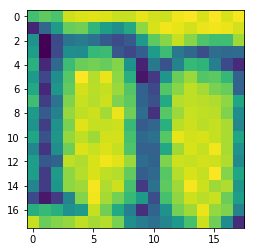

In [11]:
%matplotlib inline
pick_random = random.randrange(len(img_set))
# print(img_set[pick_random])
plt.imshow(img_set[pick_random])

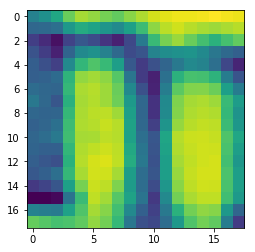

In [13]:
test = blur_img(img_set[pick_random], blur_level=1.5+random.random())
plt.imshow(test)

In [14]:
print('Number of images:', len(img_set), 'Size:', img_set[0].shape)

Number of images: 150520 Size: (18, 18)


### Building Model

Placeholders

In [15]:
IMGSIZE = img_set[0].shape[0]
COLOR_CHANNELS = 1
print(IMGSIZE)
data_ph = tf.placeholder('float32',[None, IMGSIZE*IMGSIZE*COLOR_CHANNELS])
output_ph = tf.placeholder('float32',[None, IMGSIZE*IMGSIZE*COLOR_CHANNELS])
learning_rate = tf.placeholder('float', [], name = 'learning_rate_ph')

18


In [16]:
def init_weights(shape):
    init_random_dist = tf.truncated_normal(shape, stddev = 1.1)
    return tf.Variable(init_random_dist)

In [17]:
def init_bias(shape):
    init_bias_vals = tf.constant(0.1, shape=shape)
    return tf.Variable(init_bias_vals)

In [18]:
def conv2d(x, W):
    #x -> [batch, H, W, Channels]
    #W -> [filter H, filter W, Channels IN, Channels Out]
    return tf.nn.conv2d(x, W, strides = [1,1,1,1], padding='SAME')

In [19]:
def deconvolutional_layer(input_x, shape):
    W = init_weights(shape)
    b = init_bias([shape[3]])
    return tf.nn.relu(tf.nn.conv2d_transpose(input_x, W, shape, strides = [1,1,1,1], padding='SAME')+b)

In [20]:
def  convolutional_layer(input_x, shape):
    W = init_weights(shape)
    b = init_bias([shape[3]])
    return tf.nn.relu(conv2d(input_x, W)+b)

Layers

In [21]:
hl1 = tf.reshape(data_ph, [-1, IMGSIZE, IMGSIZE, 1])
hl2 = convolutional_layer(hl1, [1, 1, 1, 12])
hl3 = convolutional_layer(hl2, [3, 3, 12, 12])
hl4 = convolutional_layer(hl3, [3, 3, 12, 12])
hl5 = convolutional_layer(hl4, [1, 1, 12, 1])
ol = tf.nn.sigmoid(hl5)
ol_residual = tf.reshape(ol, [-1, IMGSIZE*IMGSIZE*COLOR_CHANNELS])
# ol = tf.contrib.layers.fully_connected(ol_residual, IMGSIZE*IMGSIZE*COLOR_CHANNELS, activation_fn=tf.nn.sigmoid)
ol = ol_residual

mean1, var1 = tf.nn.moments(output_ph, axes=[0])
mean2, var2 = tf.nn.moments(ol, axes=[0])
# print(mean.shape)
loss = tf.reduce_mean((ol - output_ph)**2)+(tf.reduce_mean(mean2)-tf.reduce_mean(mean1))**2
train = tf.train.AdamOptimizer(learning_rate).minimize(loss)

Load Batch

In [22]:
def load_batch(size, blur):
    batch_x, batch_y = [], []
    for _ in range(size):
        rand_val = random.randrange(0, len(img_set))
        if rand_val == pick_random:
            rand_val = rand_val + random.randrange(0, 10)
        if blur:
            batch_x.append(np.array(blur_img(img_set[rand_val], blur_level=1.5+random.random())).ravel())
        else:
            batch_x.append(np.array(img_set[rand_val]).ravel())
        batch_y.append(np.array(img_set[rand_val]).ravel())
    return batch_x, batch_y

Running session

In [23]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

<IPython.core.display.Javascript object>


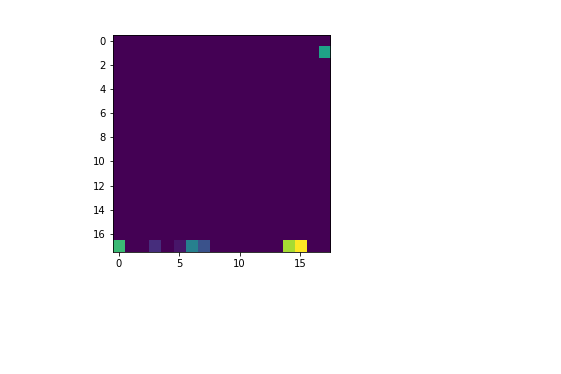

0.278916
0.049364
0.0503226
0.0426643
0.045832
0.0459342
0.0387472
0.049023
0.0379188
0.0431255
0.0435574
0.0468256
0.0469877
0.0473533
0.0434616
0.0414135
0.0412101
0.0471223
0.0367115
0.0465884
0.0389355
0.0428641
0.0489964
0.0388488
0.0450779
0.0460198
0.0352979
0.0503283
0.0437922
0.0428943
0.0451634
0.0402557
0.0461397
0.0417765
0.0481597
0.0434681


In [ ]:
%matplotlib notebook
import time

start = time.time()
batch_size = 50
steps = 550000
rate = 3e-3

fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()

with tf.Session() as sess:
    sess.run(init)
    for i in range(steps):
        batch_x, batch_y = load_batch(batch_size, blur=True)
        feed = {data_ph:batch_x, output_ph:batch_y, learning_rate:rate}
        sess.run(train, feed_dict=feed)
        
        if i%100 == 0:
            last_loss = sess.run(loss, feed_dict = feed)
            print(last_loss)
            if last_loss<0.0055:
                rate = 3e-5
            pred = sess.run(ol, feed_dict={data_ph:[np.array(blur_img(img_set[pick_random], blur_level=2)).ravel()]})
#             pred = sess.run(ol, feed_dict={data_ph:[np.array(img_set[pick_random]).ravel()]})
            ax.clear()
            ax.imshow(np.reshape(pred, [IMGSIZE, IMGSIZE]))
            fig.canvas.draw()

end = time.time()
elapsed = end - start
print(elapsed)

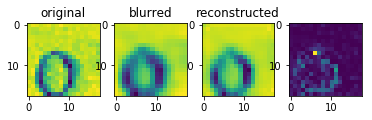

In [109]:
%matplotlib inline
fig = plt.figure()
ax1 = fig.add_subplot(1,4,1)
ax1.imshow(img_set[pick_random])
ax1.set_title('original')
ax2 = fig.add_subplot(1,4,3)
ax2.imshow(np.reshape(pred, [IMGSIZE,IMGSIZE]))
ax2.set_title('reconstructed')
ax3 = fig.add_subplot(1,4,4)
ax3.imshow((img_set[pick_random]-np.reshape(pred, [IMGSIZE,IMGSIZE]))**2)
ax4 = fig.add_subplot(1,4,2)
ax4.imshow(blur_img(img_set[pick_random], blur_level=2))
ax4.set_title('blurred')

In [ ]:
time.strftime("%H:%M:%S", time.gmtime(elapsed))

In [21]:
%matplotlib inline
# plt.imshow(np.reshape(pred, [63, 108]))
with tf.Session as sess:
    pred = sess.run(ol, feed_dict={data_ph:[np.array(blur_img(img_set[1], blur_level=3+random.random())).ravel()]})
    plt.imshow(np.reshape(pred, [42, 42]))

AttributeError: __exit__